In [ ]:
# 1. Install PySpark and Java
!pip install pyspark
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

In [ ]:
# 2. Start Spark Session
from pyspark.sql import SparkSession
import os

spark = SparkSession.builder \
    .appName("CreditRisk_RD_Project") \
    .getOrCreate()

In [ ]:
# 3. Download the Dataset directly
!wget -q https://raw.githubusercontent.com/nsethi31/Kaggle-Data-Credit-Card-Fraud-Detection/master/creditcard.csv

In [ ]:
# 4. Load into Spark DataFrame
df = spark.read.csv("creditcard.csv", header=True, inferSchema=True)

In [ ]:
# 5. Check the structure
df.printSchema()
df.show(5)

root
 |-- Time: double (nullable = true)
 |-- V1: double (nullable = true)
 |-- V2: double (nullable = true)
 |-- V3: double (nullable = true)
 |-- V4: double (nullable = true)
 |-- V5: double (nullable = true)
 |-- V6: double (nullable = true)
 |-- V7: double (nullable = true)
 |-- V8: double (nullable = true)
 |-- V9: double (nullable = true)
 |-- V10: double (nullable = true)
 |-- V11: double (nullable = true)
 |-- V12: double (nullable = true)
 |-- V13: double (nullable = true)
 |-- V14: double (nullable = true)
 |-- V15: double (nullable = true)
 |-- V16: double (nullable = true)
 |-- V17: double (nullable = true)
 |-- V18: double (nullable = true)
 |-- V19: double (nullable = true)
 |-- V20: double (nullable = true)
 |-- V21: double (nullable = true)
 |-- V22: double (nullable = true)
 |-- V23: double (nullable = true)
 |-- V24: double (nullable = true)
 |-- V25: double (nullable = true)
 |-- V26: double (nullable = true)
 |-- V27: double (nullable = true)
 |-- V28: double (nulla

In [ ]:
from pyspark.sql import functions as F

# 1. Check for Missing Values in all columns
null_counts = df.select([F.count(F.when(F.col(c).isNull(), c)).alias(c) for c in df.columns])
print("Null Value Counts:")
null_counts.show()

Null Value Counts:
+----+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+------+-----+
|Time| V1| V2| V3| V4| V5| V6| V7| V8| V9|V10|V11|V12|V13|V14|V15|V16|V17|V18|V19|V20|V21|V22|V23|V24|V25|V26|V27|V28|Amount|Class|
+----+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+------+-----+
|   0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|     0|    0|
+----+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+------+-----+



In [ ]:
# 2. Financial Logic Check: Filter out invalid data (e.g., negative amounts)
# create a 'Clean' dataset and an 'Invalid' dataset for the R&D report
invalid_data = df.filter((F.col("Amount") < 0) | (F.col("Time") < 0))
clean_df = df.filter((F.col("Amount") >= 0) & (F.col("Time") >= 0))

print(f"Total Records: {df.count()}")
print(f"Invalid Records found: {invalid_data.count()}")

Total Records: 284807
Invalid Records found: 0


In [ ]:
# 3. Statistical Profiling of the 'Amount' column
print("Statistical Summary of Transaction Amounts:")
clean_df.select("Amount").describe().show()

Statistical Summary of Transaction Amounts:
+-------+-----------------+
|summary|           Amount|
+-------+-----------------+
|  count|           284807|
|   mean|88.34961925095102|
| stddev|250.1201092401863|
|    min|              0.0|
|    max|         25691.16|
+-------+-----------------+



In [ ]:
# 4. Save a sample of 'High Value' transactions for later Anomaly Research
high_value_df = clean_df.filter(F.col("Amount") > 1000)
print(f"Number of High Value Transactions (> 1000): {high_value_df.count()}")

Number of High Value Transactions (> 1000): 2940


In [ ]:
import pandas as pd
from sklearn.ensemble import IsolationForest
import numpy as np

# 1. Method 1: Statistical Outlier Detection (using PySpark)
mean_val = 88.35
stddev_val = 250.12
threshold = mean_val + (3 * stddev_val)

stat_outliers = clean_df.filter(F.col("Amount") > threshold)
print(f"Method 1 (Z-Score) found {stat_outliers.count()} outliers.")

Method 1 (Z-Score) found 4076 outliers.


In [ ]:
# 2. Method 2: ML-based Detection (Using a sample for Research)
# take a sample of 20,000 records to represent the R&D test set
pdf = clean_df.sample(False, 0.1, seed=42).toPandas()

In [ ]:
# Initialize Isolation Forest
iso_forest = IsolationForest(contamination=0.01, random_state=42)
# 'contamination=0.01' means we expect 1% of data to be anomalies
pdf['anomaly'] = iso_forest.fit_predict(pdf[['Amount', 'V1', 'V2', 'V3']]) # Using subset of features

In [ ]:
# -1 indicates an anomaly
ml_outliers = pdf[pdf['anomaly'] == -1]
print(f"Method 2 (Isolation Forest) found {len(ml_outliers)} anomalies in the sample.")

Method 2 (Isolation Forest) found 285 anomalies in the sample.


In [ ]:
# 3. R&D Verification: How many ML anomalies are actually labeled as 'Class 1' (Fraud)?
fraud_detected = ml_outliers[ml_outliers['Class'] == 1].shape[0]
print(f"Research Finding: ML Method caught {fraud_detected} known fraud cases in the sample.")

Research Finding: ML Method caught 14 known fraud cases in the sample.


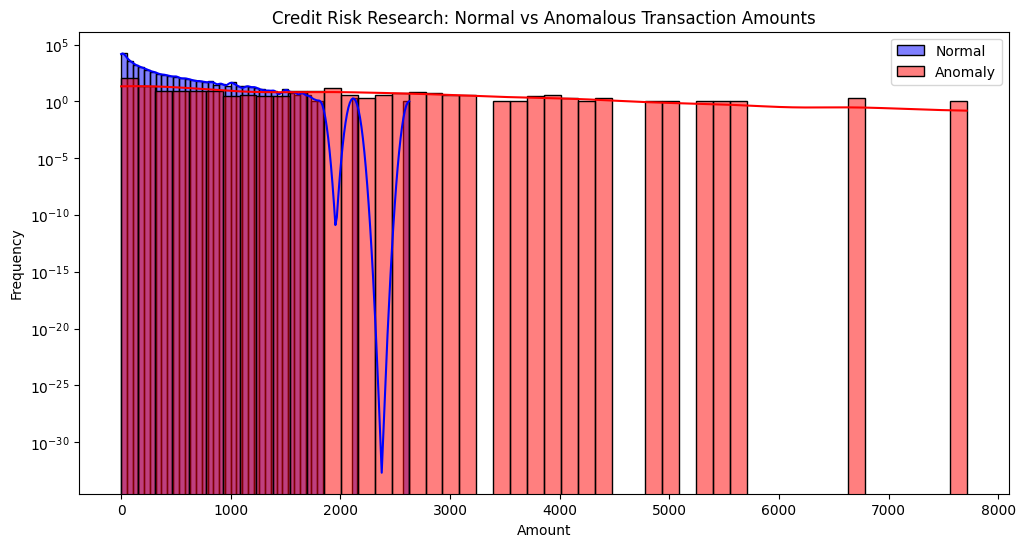

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Visualization: Amount Distribution for ML-detected Anomalies
plt.figure(figsize=(12, 6))
sns.histplot(pdf[pdf['anomaly'] == 1]['Amount'], color='blue', label='Normal', kde=True, bins=50)
sns.histplot(pdf[pdf['anomaly'] == -1]['Amount'], color='red', label='Anomaly', kde=True, bins=50)
plt.title('Credit Risk Research: Normal vs Anomalous Transaction Amounts')
plt.xlabel('Amount')
plt.ylabel('Frequency')
plt.legend()
plt.yscale('log') # Log scale because of the high Max value  found earlier
plt.show()

In [ ]:
# 2. Key Findings for the Resume
print("--- FINAL R&D INSIGHTS ---")
avg_anomaly_amount = pdf[pdf['anomaly'] == -1]['Amount'].mean()
avg_normal_amount = pdf[pdf['anomaly'] == 1]['Amount'].mean()
print(f"Average Normal Transaction: ${avg_normal_amount:.2f}")
print(f"Average Anomalous Transaction: ${avg_anomaly_amount:.2f}")

--- FINAL R&D INSIGHTS ---
Average Normal Transaction: $76.65
Average Anomalous Transaction: $1064.14
